In [1]:
!pip3 install -q http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

tcmalloc: large alloc 1073750016 bytes == 0x5df0c000 @  0x7fc185d5f2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 1.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [21]:
%matplotlib inline
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def plot_kernel(model):
    model_weights = model.state_dict()
    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(model_weights['conv1.weight']):
    #print(filt[0, :, :])
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt[0, :, :], cmap="gray")
        plt.axis('off')
    
    plt.show()

def plot_kernel_output(model,images):
    fig1 = plt.figure()
    plt.figure(figsize=(1,1))
    
    img_normalized = (images[0] - images[0].min()) / (images[0].max() - images[0].min())
    plt.imshow(img_normalized.numpy().transpose(1,2,0))
    plt.show()
    output = model.conv1(images)
    layer_1 = output[0, :, :, :]
    layer_1 = layer_1.data

    fig = plt.figure()
    plt.figure(figsize=(10,10))
    for idx, filt  in enumerate(layer_1):
        if idx >= 32: continue
        plt.subplot(4,8, idx + 1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
    plt.show()

def test_accuracy(net, dataloader):
  ########TESTING PHASE###########
  
    #check accuracy on whole test set
    correct = 0
    total = 0
    net.eval() #important for deactivating dropout and correctly use batchnorm accumulated statistics
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: %d %%' % (
    accuracy))
    return accuracy

    
n_classes = 100 
# function to define an old style fully connected network (multilayer perceptrons)
class old_nn(nn.Module):
    def __init__(self):
        super(old_nn, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
      
      
#function to define the convolutional network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #conv2d first parameter is the number of kernels at input (you get it from the output value of the previous layer)
        #conv2d second parameter is the number of kernels you wanna have in your convolution, so it will be the n. of kernels at output.
        #conv2d third, fourth and fifth parameters are, as you can read, kernel_size, stride and zero padding :)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv_final = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(64 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, n_classes) #last FC for classification 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.pool(self.conv_final(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        #hint: dropout goes here!
        x = self.fc2(x)
        return x

In [7]:
      ####RUNNING CODE FROM HERE:
      
#transform are heavily used to do simple and complex transformation and data augmentation
transform_train = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose(
    [
     transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0,drop_last=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0,drop_last=True)


dataiter = iter(trainloader)

###OPTIONAL:
# show images just to understand what is inside the dataset ;)
#images, labels = dataiter.next()
#imshow(torchvision.utils.make_grid(images))
####


#create the old style NN network
#net = old_nn()
###

net = CNN()
####
#for Residual Network:
#net = models.resnet18(pretrained=True)
#net.fc = nn.Linear(512, n_classes) #changing the fully connected layer of the already allocated network
####

###OPTIONAL:
#print("####plotting kernels of conv1 layer:####")
#plot_kernel(net)
####


net = net.cuda()

criterion = nn.CrossEntropyLoss().cuda() #it already does softmax computation for use!
optimizer = optim.Adam(net.parameters(), lr=0.0001) #better convergency w.r.t simple SGD :)

###OPTIONAL:
#print("####plotting output of conv1 layer:#####")
#plot_kernel_output(net,images)  
###
print('Data ready')

Files already downloaded and verified
Files already downloaded and verified
Data ready


In [8]:
########TRAINING PHASE###########
#1/6
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!

n_epochs = 20
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_loss_print))
            running_loss = 0.0
    test_accuracy(net,testloader)
print('Finished Training')

[1,   195] loss: 4.226
Accuracy of the network on the test set: 10 %
[2,   195] loss: 3.806
Accuracy of the network on the test set: 14 %
[3,   195] loss: 3.619
Accuracy of the network on the test set: 16 %
[4,   195] loss: 3.480
Accuracy of the network on the test set: 18 %
[5,   195] loss: 3.369
Accuracy of the network on the test set: 20 %
[6,   195] loss: 3.271
Accuracy of the network on the test set: 21 %
[7,   195] loss: 3.186
Accuracy of the network on the test set: 23 %
[8,   195] loss: 3.109
Accuracy of the network on the test set: 23 %
[9,   195] loss: 3.037
Accuracy of the network on the test set: 24 %
[10,   195] loss: 2.967
Accuracy of the network on the test set: 25 %
[11,   195] loss: 2.900
Accuracy of the network on the test set: 25 %
[12,   195] loss: 2.840
Accuracy of the network on the test set: 26 %
[13,   195] loss: 2.769
Accuracy of the network on the test set: 27 %
[14,   195] loss: 2.707
Accuracy of the network on the test set: 27 %
[15,   195] loss: 2.643
Accur

In [ ]:
########TRAINING PHASE###########
#2/6
n_loss_print = len(trainloader)  #print every epoch, use smaller numbers if you wanna print loss more often!
n_epochs = 20
stats = np.empty((n_epochs,2))
for epoch in range(n_epochs):  # loop over the dataset multiple times
    net.train() #important for activating dropout and correctly train batchnorm
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs and cast them into cuda wrapper
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % n_loss_print == (n_loss_print -1):    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / n_loss_print))
            stats[epoch][1] = running_loss / n_loss_print
            running_loss = 0.0
    stats[epoch][0] = test_accuracy(net,testloader)
print('Finished Training')
param_range = np.arange(n_epochs+1)
plt.ylim(0.0, 100.0)
plt.semilogx(param_range, stats[:,0], label='Accuracy', lw=lw)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


(20,)


ValueError: x and y must have same first dimension, but have shapes (21,) and (20,)

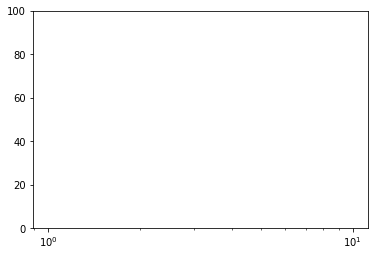

In [24]:
stats = np.empty(n_epochs)
print(stats.shape)
stats = np.empty((n_epochs,2))
param_range = np.arange(n_epochs+1)
lw = 1
plt.ylim(0.0, 100.0)
plt.semilogx(param_range, stats[:,0], label='Accuracy', lw=lw)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()